In [1]:
import os, shutil
import numpy as np

from matplotlib import image, pyplot
from skimage.transform import resize


from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout

from keras import callbacks
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, f1_score, recall_score,classification_report,roc_curve, auc 
from sklearn.utils import class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn import svm
from PIL import Image,ImageFile

In [2]:
resultPath = 'C:/Users/HP/Downloads/Results/CNN'

In [3]:
DATA_PATH = "C:/Users/HP/Downloads/spam_and_ham/"
spamData=[]
label=[]
hashList=[]
count=-1
i = 0
for folder in os.listdir(DATA_PATH):
    print(">>>Reading ",folder)
    count+=1
    i = i+1
    if i ==1 :
        for file in os.listdir(DATA_PATH+folder):
            if(str(file).endswith('.jpg') or str(file).endswith('.JPG') or str(file).endswith('.jpeg') or str(file).endswith('.JPEG')or str(file).endswith('.PNG')or str(file).endswith('.png') or str(file).endswith('.bmp')or str(file).endswith('.BMP')):
                ImageFile.LOAD_TRUNCATED_IMAGES = True
                try:
                    img = image.imread(DATA_PATH+folder+'/'+file)
                except:
                    continue
                hsh = hash(tuple(np.array(img).flatten()))
                if(hsh not in hashList):
                    spamData.append(resize(img, (156, 156, 3)))
                    hashList.append(hsh)
                    label.append(count)
    else:
        for file in os.listdir(DATA_PATH+folder):
            if(str(file).endswith('.PNG')or str(file).endswith('.png') or str(file).endswith('.bmp')or str(file).endswith('.BMP')):
                ImageFile.LOAD_TRUNCATED_IMAGES = True
                try:
                    img = image.imread(DATA_PATH+folder+'/'+file)
                except:
                    continue
                hsh = hash(tuple(np.array(img).flatten()))
                if(hsh not in hashList):
                    spamData.append(resize(img, (156, 156, 3)))
                    hashList.append(hsh)
                    label.append(count)
spamData=np.array(spamData)
label=np.array(label)

>>>Reading  personal_image_ham
>>>Reading  spam_archive


In [4]:
print("Number of HAM",len(label[label==0]))
print("Number of SPAM",len(label[label==1]))

Number of HAM 1519
Number of SPAM 5084


In [5]:
print("Spam data shape : ",spamData.shape," Label shape : ",label.shape)

Spam data shape :  (6603, 156, 156, 3)  Label shape :  (6603,)


In [6]:
test_valid_Percentage = 0.3
x_train,x_test,y_train,y_test = train_test_split(spamData,label,test_size = test_valid_Percentage,random_state=42, stratify=label,shuffle=True)

In [7]:
print("x_train shape : ",x_train.shape," y_train shape : ",y_train.shape)
print("x_test shape : ",x_test.shape," y_test shape : ",y_test.shape)

x_train shape :  (4622, 156, 156, 3)  y_train shape :  (4622,)
x_test shape :  (1981, 156, 156, 3)  y_test shape :  (1981,)


In [8]:
print("Number of train SPAM",len(y_train[y_train==0]))
print("Number of train HAM",len(y_train[y_train==1]))

print("Number of test SPAM",len(y_test[y_test==0]))
print("Number of test HAM",len(y_test[y_test==1]))

Number of train SPAM 1063
Number of train HAM 3559
Number of test SPAM 456
Number of test HAM 1525


In [9]:
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)

print("y_train_oh shape : ",y_train_oh.shape," y_test_oh shape : ",y_test_oh.shape)

y_train_oh shape :  (4622, 2)  y_test_oh shape :  (1981, 2)


In [22]:
NO_OF_EPOCHS=20
BATCH_SIZE=32

model=Sequential()
model.add(Conv2D(32,kernel_size=3, padding='same',activation='relu',input_shape=(156, 156,3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64,kernel_size=3, padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128,kernel_size=3, padding='same',activation='relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 156, 156, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 78, 78, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 78, 78, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 39, 39, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 39, 39, 128)       73856     
                                                                 
 dropout (Dropout)           (None, 39, 39, 128)       0

In [23]:
checkpointer = callbacks.ModelCheckpoint(filepath=resultPath+"/checkpoint-{epoch:04d}.hdf5", verbose=1, save_best_only=True, monitor='val_acc',mode='max')
csv_logger = CSVLogger(resultPath+'/result_logger.csv',separator=',', append=False)
reduce_lr = ReduceLROnPlateau(monitor='acc', factor=0.2, patience=2, min_lr=0.001)
model.fit(x_train,y_train,epochs=NO_OF_EPOCHS,verbose=1,batch_size=BATCH_SIZE,validation_split = 0.2,callbacks=[checkpointer,csv_logger,reduce_lr])

Epoch 1/20
145/145 [==============================] - 140s 931ms/step - loss: 0.4117 - accuracy: 0.8780 - val_loss: 0.2182 - val_accuracy: 0.9213 - lr: 0.0010
Epoch 2/20
145/145 [==============================] - 125s 865ms/step - loss: 0.1997 - accuracy: 0.9275 - val_loss: 0.1814 - val_accuracy: 0.9248 - lr: 0.0010
Epoch 3/20
145/145 [==============================] - 126s 869ms/step - loss: 0.1765 - accuracy: 0.9321 - val_loss: 0.1930 - val_accuracy: 0.9379 - lr: 0.0010
Epoch 4/20
145/145 [==============================] - 132s 912ms/step - loss: 0.1634 - accuracy: 0.9373 - val_loss: 0.1579 - val_accuracy: 0.9359 - lr: 0.0010
Epoch 5/20
145/145 [==============================] - 134s 923ms/step - loss: 0.1291 - accuracy: 0.9466 - val_loss: 0.1589 - val_accuracy: 0.9414 - lr: 0.0010
Epoch 6/20
145/145 [==============================] - 130s 897ms/step - loss: 0.1138 - accuracy: 0.9533 - val_loss: 0.1613 - val_accuracy: 0.9455 - lr: 0.0010
Epoch 7/20
145/145 [==========================

In [24]:
prediction_prob1 = model.predict(x_test,verbose=1)
y_pred=np.round(prediction_prob1)

62/62 [==============================] - 11s 170ms/step


In [25]:
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred,average='binary'))
print(recall_score(y_test,y_pred,average='binary'))
print(f1_score(y_test,y_pred,average='binary'))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.9444724886421
0.9645436638214051
0.9632786885245902
0.9639107611548556
[[ 402   54]
 [  56 1469]]
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       456
           1       0.96      0.96      0.96      1525

    accuracy                           0.94      1981
   macro avg       0.92      0.92      0.92      1981
weighted avg       0.94      0.94      0.94      1981



In [26]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)
print(class_weights)

[2.17403575 0.6493397 ]


In [27]:
model1=Sequential()
model1.add(Conv2D(128,kernel_size=3, padding='same',activation='relu',input_shape=(156, 156,3)))
model1.add(MaxPool2D(pool_size=(4, 4)))
model1.add(Conv2D(128,kernel_size=3, padding='same',activation='relu'))
model1.add(MaxPool2D(pool_size=(3, 3)))
model1.add(Conv2D(256,kernel_size=3, padding='same',activation='relu'))
model1.add(Dropout(0.1))
model1.add(Flatten())
model1.add(Dense(128,activation='relu'))
model1.add(Dropout(0.1))
model1.add(Dense(2,activation='softmax'))
model1.summary()
model1.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 156, 156, 128)     3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 39, 39, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 39, 39, 128)       147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 dropout_2 (Dropout)         (None, 13, 13, 256)      

In [29]:
checkpointer = callbacks.ModelCheckpoint(filepath=resultPath+"/checkpoint-{epoch:04d}.hdf5", verbose=1, save_best_only=True, monitor='val_acc',mode='max')
csv_logger = CSVLogger(resultPath+'/result_logger.csv',separator=',', append=False)
reduce_lr = ReduceLROnPlateau(monitor='acc', factor=0.2, patience=2, min_lr=0.001)
model1.fit(x_train,y_train,epochs=NO_OF_EPOCHS,verbose=1,class_weights = class_weights,batch_size=BATCH_SIZE,validation_split = 0.2,callbacks=[checkpointer,csv_logger,reduce_lr])

Epoch 1/20
145/145 [==============================] - 147s 984ms/step - loss: 0.3645 - accuracy: 0.8916 - val_loss: 0.1921 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 2/20
145/145 [==============================] - 125s 862ms/step - loss: 0.1995 - accuracy: 0.9251 - val_loss: 0.2151 - val_accuracy: 0.9187 - lr: 0.0010
Epoch 3/20
145/145 [==============================] - 125s 862ms/step - loss: 0.1662 - accuracy: 0.9314 - val_loss: 0.1665 - val_accuracy: 0.9364 - lr: 0.0010
Epoch 4/20
145/145 [==============================] - 125s 861ms/step - loss: 0.1286 - accuracy: 0.9479 - val_loss: 0.2070 - val_accuracy: 0.9112 - lr: 0.0010
Epoch 5/20
145/145 [==============================] - 125s 865ms/step - loss: 0.1089 - accuracy: 0.9561 - val_loss: 0.1612 - val_accuracy: 0.9399 - lr: 0.0010
Epoch 6/20
145/145 [==============================] - 125s 863ms/step - loss: 0.0831 - accuracy: 0.9662 - val_loss: 0.2350 - val_accuracy: 0.9394 - lr: 0.0010
Epoch 7/20
145/145 [==========================

In [30]:
prediction_prob = model1.predict(x_test,verbose=1)
y_pred=np.round(prediction_prob)

62/62 [==============================] - 11s 172ms/step


In [31]:
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred,average='binary'))
print(recall_score(y_test,y_pred,average='binary'))
print(f1_score(y_test,y_pred,average='binary'))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.9424533064109036
0.9700199866755497
0.9547540983606557
0.9623265036351619
[[ 411   45]
 [  69 1456]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       456
           1       0.97      0.95      0.96      1525

    accuracy                           0.94      1981
   macro avg       0.91      0.93      0.92      1981
weighted avg       0.94      0.94      0.94      1981



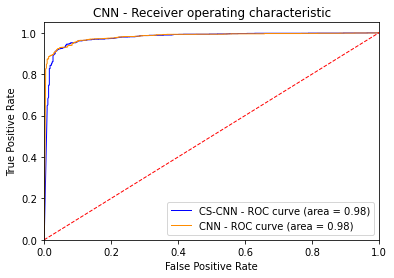

In [32]:

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, prediction_prob)
    roc_auc[i] = auc(fpr[i], tpr[i])


pyplot.figure()
pyplot.plot(fpr[0], tpr[0],color='blue', lw=1, label='CS-CNN - ROC curve (area = %0.2f)' % roc_auc[0])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, prediction_prob1)
    roc_auc[i] = auc(fpr[i], tpr[i])
pyplot.plot(fpr[0], tpr[0],color='darkorange', lw=1, label='CNN - ROC curve (area = %0.2f)' % roc_auc[0])
pyplot.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--')
pyplot.xlim([0.0, 1.0])
pyplot.ylim([0.0, 1.05])
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('CNN - Receiver operating characteristic')
pyplot.legend(loc="lower right")
pyplot.show()